In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import warnings
import seaborn as sns
import ehrapy as ep
import anndata as ad

plt.style.use("ggplot")
warnings.filterwarnings("ignore")

# Benchmark dataset creation
# https://github.com/YerevaNN/mimic3-benchmarks
#https://github.com/cmsalgado/book_chapter/blob/master/book_chapter.ipynb

In [57]:
df = pd.read_csv('notebooks/ehrapy_data/icd_chart_60filtered.csv.gz')
df2 = pd.read_csv('notebooks/ehrapy_data/icu_stay_diag.csv.gz')
cluster_df = pd.read_csv('notebooks/tables/leiden_clusters.csv')
cluster_df = cluster_df.reset_index()
icu_df = df2.merge(cluster_df[["stay_id", "leiden_0_3", 'annotation']], on="stay_id")

In [58]:
wide_df = df.pivot_table(
    index=["stay_id", "event_time_from_admit"],
    columns="label",
    values="valuenum",
    aggfunc="first"  # or "mean" if multiple values per label per time
).reset_index()

In [59]:
# Create dictionaries for metadata (label → unit/category)
unit_lookup = df.dropna(subset=["unitname"]).drop_duplicates(subset=["label"])[["label", "unitname"]].set_index("label").to_dict()["unitname"]
category_lookup = df.drop_duplicates(subset=["label"])[["label", "category"]].set_index("label").to_dict()["category"]


In [60]:
# Convert relevant columns to datetime
icu_df['intime'] = pd.to_datetime(icu_df['intime'])
icu_df['outtime'] = pd.to_datetime(icu_df['outtime'])
icu_df['dod'] = pd.to_datetime(icu_df['dod'], errors='coerce')

# Create masks for deaths during stay and after discharge
died_mask = icu_df['dod'].notna()
during_stay_mask = died_mask & (icu_df['dod'] >= icu_df['intime']) & (icu_df['dod'] <= icu_df['outtime'])
after_discharge_mask = died_mask & (icu_df['dod'] > icu_df['outtime'])

# Calculate days since admission (during stay)
icu_df['days_since_admit'] = np.where(
    during_stay_mask,
    (icu_df['dod'] - icu_df['intime']).dt.days,
    np.nan
)

# Calculate days after discharge
icu_df['days_after_discharge'] = np.where(
    after_discharge_mask,
    (icu_df['dod'] - icu_df['outtime']).dt.days,
    np.nan
)

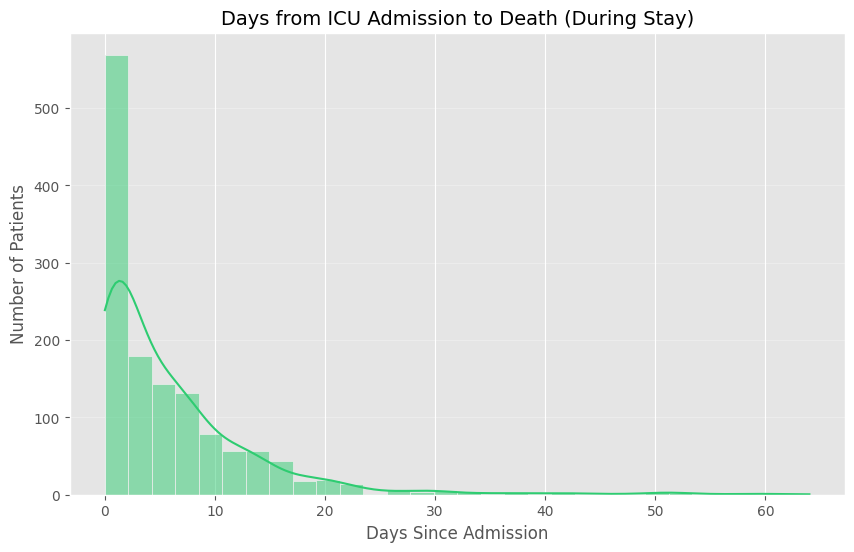

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter rows where death occurred during the stay
died_during_stay = icu_df[icu_df['days_since_admit'].notna()]

plt.figure(figsize=(10, 6))
sns.histplot(
    data=died_during_stay,
    x='days_since_admit',
    bins=30,
    kde=True,
    color='#2ecc71'
)
plt.title('Days from ICU Admission to Death (During Stay)', fontsize=14)
plt.xlabel('Days Since Admission', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

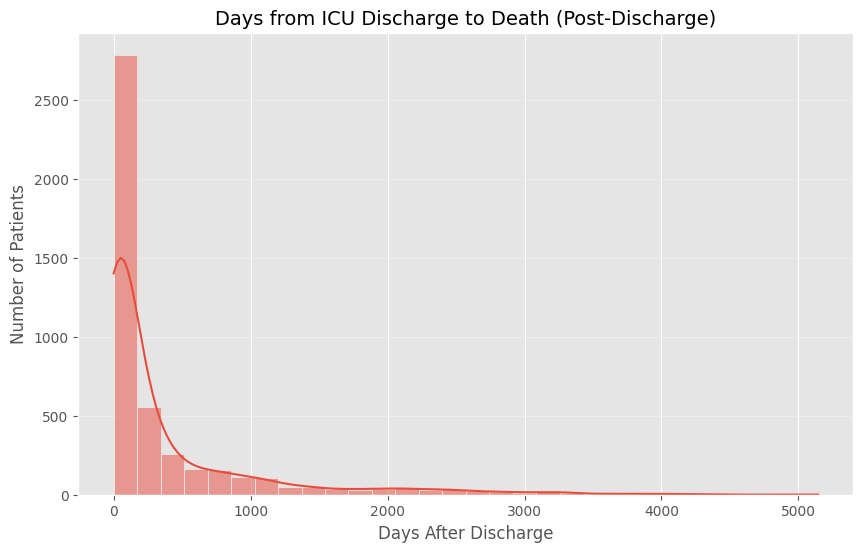

In [39]:
# Filter rows where death occurred after discharge
died_after_discharge = icu_df[icu_df['days_after_discharge'].notna()]

plt.figure(figsize=(10, 6))
sns.histplot(
    data=died_after_discharge,
    x='days_after_discharge',
    bins=30,
    kde=True,
    color='#e74c3c'
)
plt.title('Days from ICU Discharge to Death (Post-Discharge)', fontsize=14)
plt.xlabel('Days After Discharge', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

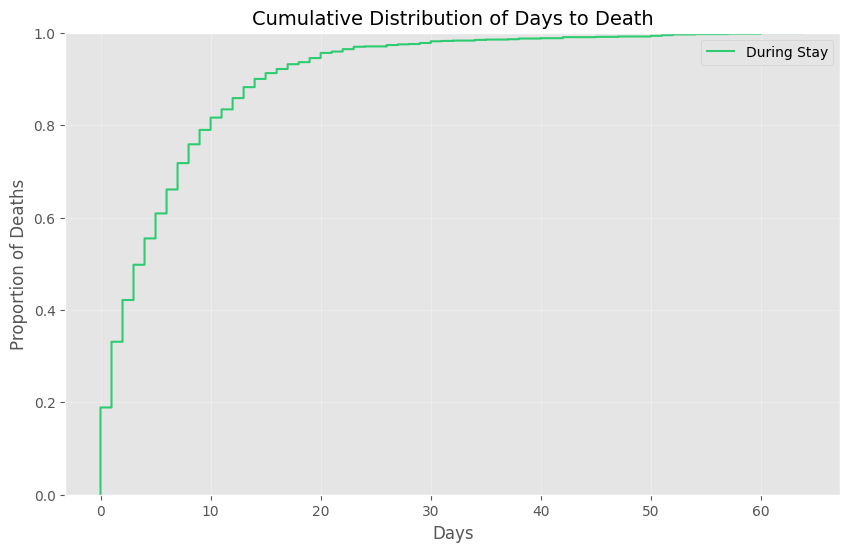

In [40]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(
    data=died_during_stay['days_since_admit'],
    color='#2ecc71',
    label='During Stay'
)
# sns.ecdfplot(
#     data=died_after_discharge['days_after_discharge'],
#     color='#e74c3c',
#     label='Post-Discharge'
# )
plt.title('Cumulative Distribution of Days to Death', fontsize=14)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Proportion of Deaths', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [61]:
summary_stats = pd.DataFrame({
    'During Stay': died_during_stay['days_since_admit'].describe(),
    'Post-Discharge': died_after_discharge['days_after_discharge'].describe()
}).T.round(2)

print(summary_stats)

                 count    mean     std  min  \
During Stay     1350.0    6.13    8.04  0.0   
Post-Discharge  4569.0  386.72  690.43  0.0   

                 25%   50%    75%     max  
During Stay      1.0   4.0    8.0    64.0  
Post-Discharge  16.0  86.0  389.0  5144.0  


In [86]:
# --- Step 1: Preprocess wide_df ---
# Convert event_time_from_admit to hours since admission
# Convert time to hours since admission and floor negative values at 0
wide_df['hours_since_admit'] = (
    pd.to_timedelta(wide_df['event_time_from_admit'])
    .dt.total_seconds() / 3600  # Convert to hours
).clip(lower=0)  # Floor negative values at 0

wide_df["event_time_from_admit"] = pd.to_timedelta(wide_df["event_time_from_admit"])
wide_df["day"] = wide_df["event_time_from_admit"].dt.days + 1

KeyError: 'event_time_from_admit'

In [84]:
wide_df = wide_df.drop(columns=["event_time_from_admit"])

In [85]:
adata = ep.io.df_to_anndata(wide_df, 
            index_column='stay_id',
            columns_obs_only=['stay_id', 'subject_id', 'hadm_id', 'dod', 'intime', 'outtime', 'ALT', 'AST', 'ICD_J18', 'ICD_E87', 'ICD_I50', 'ICD_N17', 'ICD_J96', 'gender', 'insurance', 'ethnicity',  'annotation', 'icu_stay_days', 'los'])


ValueError: Columns ['subject_id', 'hadm_id', 'dod', 'intime', 'outtime', 'ICD_J18', 'ICD_E87', 'ICD_I50', 'ICD_N17', 'ICD_J96', 'gender', 'insurance', 'ethnicity', 'annotation', 'icu_stay_days', 'los'] specified in columns_obs_only are not in the DataFrame.

In [83]:
# Proceed with filtering <= 24 hours
wide_df = wide_df[wide_df['hours_since_admit'] <= 24]

In [64]:
# For static variables (e.g., Admission Weight), take the first non-NaN value per stay
static_vars = ['Admission Weight (Kg)']
static_data = wide_df.groupby('stay_id')[static_vars].first().reset_index()


In [70]:
# --- Step 2: Merge with df3 ---
df_merged = pd.merge(
    wide_df,
    icu_df,
    on='stay_id',
    how='left'
)

In [71]:
df_merged["day"] = df_merged["event_time_from_admit"].dt.days + 1

AttributeError: Can only use .dt accessor with datetimelike values

In [66]:
df_merged = df_merged.drop(columns=['event_time_from_admit'])

In [67]:
# --- Step 3: Aggregate Vital Signs ---
# Define which columns are vitals (exclude static/demographic cols)
vital_cols = [
    'Alkaline Phosphate', 'Anion gap', 'BUN', 'Calcium non-ionized',
       'Chloride (serum)', 'Creatinine (serum)', 'Glucose (serum)',
       'HCO3 (serum)', 'Heart Rate', 'Hematocrit (serum)', 'Hemoglobin',
       'Lactic Acid', 'Magnesium', 'Non Invasive Blood Pressure diastolic',
       'Non Invasive Blood Pressure mean', 'Non Invasive Blood Pressure systolic',
       'O2 Flow', 'O2 saturation pulseoxymetry', 'PTT', 'Phosphorous',
       'Platelet Count', 'Potassium (serum)', 'Prothrombin time',
       'Respiratory Rate', 'Sodium (serum)', 'Temperature Fahrenheit',
       'Total Bilirubin', 'WBC'
]

In [48]:
# Group by stay_id and hour, then aggregate
hourly_agg = (
    df_merged.groupby(['stay_id', 'hours_since_admit'])[vital_cols]
    .agg(['min', 'max', 'mean'])
    .reset_index()
)